# Airline Sentiment Analysis

## Table of Contents:
* [Data Collection](#DataCollection)
* [Data Organization](#DataOrganization)
* [Data Definition](#DataDefinition)
* [Data Cleaning](#DataCleaning)
    * [Vectorization](#Vectorization)
* [Model](#Model)

In [1]:
#imports
import pandas as pd
import numpy as np
#this will deal with punctuation
import string
import re
#from string import digits
import nltk #using the Natural Language Toolkit
from nltk.corpus import stopwords
#Lemmatization
from nltk.stem import WordNetLemmatizer
import emoji
from nltk.tokenize import word_tokenize
import seaborn as sns
from sklearn import metrics
import matplotlib.pyplot as plt

# 1. Data Collection <a class="anchor" id="DataCollection"></a>

In [2]:
#get data
tweets = pd.read_csv("../Data/Tweets.csv")

# 2. Data Organization <a class="anchor" id="DataOrganization"></a>

In [3]:
#view the heading of data
tweets.head(3)

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)


In [4]:
#check shape
print(tweets.shape)
print(tweets.info())

(14640, 15)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   tweet_id                      14640 non-null  int64  
 1   airline_sentiment             14640 non-null  object 
 2   airline_sentiment_confidence  14640 non-null  float64
 3   negativereason                9178 non-null   object 
 4   negativereason_confidence     10522 non-null  float64
 5   airline                       14640 non-null  object 
 6   airline_sentiment_gold        40 non-null     object 
 7   name                          14640 non-null  object 
 8   negativereason_gold           32 non-null     object 
 9   retweet_count                 14640 non-null  int64  
 10  text                          14640 non-null  object 
 11  tweet_coord                   1019 non-null   object 
 12  tweet_created                 14640 non-null  ob

In [5]:
#check for null values
print(tweets.isnull().sum())

#percentage of null values
print(((tweets.isnull().sum() * 100)/ len(tweets.index)))

tweet_id                            0
airline_sentiment                   0
airline_sentiment_confidence        0
negativereason                   5462
negativereason_confidence        4118
airline                             0
airline_sentiment_gold          14600
name                                0
negativereason_gold             14608
retweet_count                       0
text                                0
tweet_coord                     13621
tweet_created                       0
tweet_location                   4733
user_timezone                    4820
dtype: int64
tweet_id                         0.000000
airline_sentiment                0.000000
airline_sentiment_confidence     0.000000
negativereason                  37.308743
negativereason_confidence       28.128415
airline                          0.000000
airline_sentiment_gold          99.726776
name                             0.000000
negativereason_gold             99.781421
retweet_count                    0.0000

"airline_sentiment_gold" , "negativereason_gold", and "tweet_coord" columns are missing over 90% of their input. I will drop them

In [6]:
tweets = tweets.drop(columns=["airline_sentiment_gold" , "negativereason_gold", "tweet_coord"])

#check for more null values
print(tweets.isnull().sum())

print(((tweets.isnull().sum() * 100)/ len(tweets.index)))

tweet_id                           0
airline_sentiment                  0
airline_sentiment_confidence       0
negativereason                  5462
negativereason_confidence       4118
airline                            0
name                               0
retweet_count                      0
text                               0
tweet_created                      0
tweet_location                  4733
user_timezone                   4820
dtype: int64
tweet_id                         0.000000
airline_sentiment                0.000000
airline_sentiment_confidence     0.000000
negativereason                  37.308743
negativereason_confidence       28.128415
airline                          0.000000
name                             0.000000
retweet_count                    0.000000
text                             0.000000
tweet_created                    0.000000
tweet_location                  32.329235
user_timezone                   32.923497
dtype: float64


# 3. Data Definition <a class="anchor" id="DataDefinition"></a>

                    
 1   airline_sentiment              
 2   airline_sentiment_confidence  
 3   negativereason                 
 4   negativereason_confidence    
 5   airline                        
 6   airline_sentiment_gold         
 7   name                          
 8   negativereason_gold            
 9   retweet_count                 
 10  text                           
 11  tweet_coord                  
 12  tweet_created                 
 13  tweet_location                
 14  user_timezone   

# 4. Data Cleaning <a class="anchor" id="DataCleaning"></a>

The following needs to be done to preprocess the data:

1. Make text lowercase
2. Removing punctuations, URLs, names
3. Tokenization
4. Removing stopwords ("this", "is", etc.)
4. Stemming

In [7]:
#Lowercase
tweets["text"] = tweets["text"].str.lower()

#remove numbers
tweets["text"] = tweets["text"].str.replace('\d+', '', regex=True)

##REMOVE PUNCTUATIONS
def remove_punc(text):
    words_wo_punct = re.sub(r"[^A-Za-z0-9\s]+", "", text)
    return words_wo_punct

tweets["text"] = tweets["text"].apply(lambda x: remove_punc(x))

In [8]:
#REMOVE WHITESPACE
tweets["text"] = tweets["text"].str.strip()

#remove emoji
tweets["text"] = tweets["text"].apply(lambda x: emoji.demojize(x))
tweets["text"].head()

0                     virginamerica what dhepburn said
1    virginamerica plus youve added commercials to ...
2    virginamerica i didnt today must mean i need t...
3    virginamerica its really aggressive to blast o...
4    virginamerica and its a really big bad thing a...
Name: text, dtype: object

In [9]:
#LEMMATIZING
lemmatizer = WordNetLemmatizer()

def word_lemmatizer(text):
    word_list = nltk.word_tokenize(text)
    lem_text = ' '.join([lemmatizer.lemmatize(w) for w in word_list])
    return lem_text

tweets["text"] = tweets["text"].apply(lambda x: word_lemmatizer(x))
tweets.text.head()

0                     virginamerica what dhepburn said
1    virginamerica plus youve added commercial to t...
2    virginamerica i didnt today must mean i need t...
3    virginamerica it really aggressive to blast ob...
4    virginamerica and it a really big bad thing ab...
Name: text, dtype: object

In [10]:
#REMOVE STOPWORDS and tokenize
def remove_stopwords(text):
    tokens = word_tokenize(text)
    english_stopwords = stopwords.words('english')
    tokens_wo_stopwords = [t for t in tokens if t not in english_stopwords]
    
    return tokens_wo_stopwords

tweets["text"] = tweets["text"].apply(lambda x: remove_stopwords(str(x)))
tweets["text"].head()

0                      [virginamerica, dhepburn, said]
1    [virginamerica, plus, youve, added, commercial...
2    [virginamerica, didnt, today, must, mean, need...
3    [virginamerica, really, aggressive, blast, obn...
4             [virginamerica, really, big, bad, thing]
Name: text, dtype: object

## Polarity

In [11]:
from textblob import TextBlob, Word, Blobber
tweets['polarity']=tweets['text'].map(lambda text: TextBlob(str(text)).sentiment.polarity)
tweets.head(3)

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,name,retweet_count,text,tweet_created,tweet_location,user_timezone,polarity
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,cairdin,0,"[virginamerica, dhepburn, said]",2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada),0.0000
1,570301130888122368,positive,0.3486,NaN,0.0,Virgin America,jnardino,0,"[virginamerica, plus, youve, added, commercial...",2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada),0.0000
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,yvonnalynn,0,"[virginamerica, didnt, today, must, mean, need...",2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada),-0.3125


### Vectorization <a class="anchor" id="Vectorization"></a>

Base model

In [12]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.model_selection import train_test_split

### CountVec

In [13]:
#change text to string
tweets["text"] = tweets["text"].astype(str)

#change sentiment to int

def changeSentiment(sentiment):
    if  sentiment == "positive":
        return 1
    elif sentiment == "neutral":
        return 0
    elif sentiment == "negative":
        return -1
    
tweets['airline_sentiment'] = tweets['airline_sentiment'].apply(lambda x : changeSentiment(x))

In [14]:
#train test split

cv = CountVectorizer(max_df=0.70)
X = cv.fit_transform(tweets.text)
y = tweets['airline_sentiment']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.30)

#### get base model with Logistic Regression

In [15]:
from sklearn.linear_model import LogisticRegression
logReg = LogisticRegression(max_iter=1000).fit(X_train, y_train)
#print accuracy

print("Logistic Regression Accuracy: %0.2f%%" % (100 * logReg.score(X_test, y_test)))

training_accuracy = logReg.score(X_train, y_train)
test_accuracy = logReg.score(X_test, y_test)

print("Accuracy on training data: %0.2f" % (training_accuracy))
print("Accuracy on test data:     %0.2f" % (test_accuracy))


Logistic Regression Accuracy: 78.89%
Accuracy on training data: 0.94
Accuracy on test data:     0.79


### Tf-idf 

In [16]:
td = TfidfVectorizer(max_df=0.70)
X = td.fit_transform(tweets['text'])
y = tweets['airline_sentiment']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.30)

In [17]:
logReg = LogisticRegression(max_iter=1000).fit(X_train, y_train)
#print accuracy

print("Logistic Regression Accuracy: %0.2f%%" % (100 * logReg.score(X_test, y_test)))

training_accuracy = logReg.score(X_train, y_train)
test_accuracy = logReg.score(X_test, y_test)

print("Accuracy on training data: %0.2f" % (training_accuracy))
print("Accuracy on test data:     %0.2f" % (test_accuracy))

Logistic Regression Accuracy: 78.89%
Accuracy on training data: 0.88
Accuracy on test data:     0.79


Vectorizing with Tfidf performed the best.

In [18]:
#TF-IDF Scores
df = pd.DataFrame(X[0].T.todense(), index=td.get_feature_names(), columns=["TF-IDF"])
df = df.sort_values('TF-IDF', ascending=False)
df

,TF-IDF
dhepburn,0.818278
said,0.448619
virginamerica,0.359390
owen,0.000000
owes,0.000000
...,...
gfc,0.000000
gg,0.000000
ggqzqd,0.000000
ggreenwald,0.000000


# Model <a class="anchor" id="Model"></a>

## Naive Bayes

In [19]:
td = TfidfVectorizer(max_df=0.70)
X = td.fit_transform(tweets['text'])
y = tweets['airline_sentiment']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.30)

In [20]:
from sklearn.naive_bayes import MultinomialNB

mnb = MultinomialNB().fit(X_train, y_train)
#print accuracy

print("Naive Bayes Accuracy: %0.2f%%" % (100 * mnb.score(X_test, y_test)))

training_accuracy = mnb.score(X_train, y_train)
test_accuracy = mnb.score(X_test, y_test)

print("Accuracy on training data: %0.2f" % (training_accuracy))
print("Accuracy on test data:     %0.2f" % (test_accuracy))

Naive Bayes Accuracy: 66.60%
Accuracy on training data: 0.72
Accuracy on test data:     0.67


## Random Forest Classifier

In [21]:
td = TfidfVectorizer(max_df=0.70)
X = td.fit_transform(tweets['text'])
y = tweets['airline_sentiment']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.30)

In [22]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier().fit(X_train, y_train)
#print accuracy

print("Random Forest Accuracy: %0.2f%%" % (100 * rf.score(X_test, y_test)))

training_accuracy = rf.score(X_train, y_train)
test_accuracy = rf.score(X_test, y_test)

print("Accuracy on training data: %0.2f" % (training_accuracy))
print("Accuracy on test data:     %0.2f" % (test_accuracy))

Random Forest Accuracy: 75.27%
Accuracy on training data: 1.00
Accuracy on test data:     0.75


## Lets Improve the Model

In [23]:
from sklearn.model_selection import GridSearchCV
parameters = {
    'max_depth': [50, 100], 
    'max_features': ['auto'], 
    'n_estimators': [300, 400]
}

rf_gs = GridSearchCV(rf, parameters, cv=5) 
rf_gs.fit(X_train, y_train)

print(rf_gs.best_params_)
print(rf_gs.best_score_)
rf_gs.predict(X_train)

{'max_depth': 100, 'max_features': 'auto', 'n_estimators': 300}
0.7359494816031615


array([ 0, -1, -1, ...,  0, -1, -1])

In [24]:
rf = RandomForestClassifier(max_depth= 100, max_features= 'auto', n_estimators = 300).fit(X_train, y_train)
#print accuracy

print("Random Forest Accuracy: %0.2f%%" % (100 * rf.score(X_test, y_test)))

training_accuracy = rf.score(X_train, y_train)
test_accuracy = rf.score(X_test, y_test)

print("Accuracy on training data: %0.2f" % (training_accuracy))
print("Accuracy on test data:     %0.2f" % (test_accuracy))

Random Forest Accuracy: 73.57%
Accuracy on training data: 0.93
Accuracy on test data:     0.74


## Logistic Regression

The Logistic Regression model performed the best. 

In [25]:
td = TfidfVectorizer(min_df=5, max_df=0.70)
X = td.fit_transform(tweets['text'])
y = tweets['airline_sentiment']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.30)

In [26]:
logReg = LogisticRegression(max_iter=1000).fit(X_train, y_train)
#print accuracy

print("Logistic Regression Accuracy: %0.2f%%" % (100 * logReg.score(X_test, y_test)))

training_accuracy = logReg.score(X_train, y_train)
test_accuracy = logReg.score(X_test, y_test)

print("Accuracy on training data: %0.2f" % (training_accuracy))
print("Accuracy on test data:     %0.2f" % (test_accuracy))

Logistic Regression Accuracy: 78.83%
Accuracy on training data: 0.85
Accuracy on test data:     0.79


## The base model performed the best. 

## Let's improve the model

In [27]:
#from sklearn.model_selection import GridSearchCV
parameters = {
    'C' : [.01, .001, 1, 10, 100],#, 10, 100],
    'max_iter': [1000],
    #'penalty' : ['l1', 'l2']
}

lr_gs = GridSearchCV(logReg, parameters, cv=10) 
lr_gs.fit(X_train, y_train)

print(lr_gs.best_params_)
print(lr_gs.best_score_)
lr_gs.predict(X_train)

{'C': 1, 'max_iter': 1000}
0.7849347370426829


array([ 1, -1, -1, ...,  0,  0, -1])

In [28]:
logReg = LogisticRegression(max_iter=1000, C=1).fit(X_train, y_train)
#print accuracy

print("Logistic Regression Accuracy: %0.2f%%" % (100 * logReg.score(X_test, y_test)))

training_accuracy = logReg.score(X_train, y_train)
test_accuracy = logReg.score(X_test, y_test)

print("Accuracy on training data: %0.2f" % (training_accuracy))
print("Accuracy on test data:     %0.2f" % (test_accuracy))

Logistic Regression Accuracy: 78.83%
Accuracy on training data: 0.85
Accuracy on test data:     0.79


## Let's try with n-grams

## TF-IDF

In [29]:
ngram = (1,2)
td = TfidfVectorizer(ngram_range=ngram)
X = td.fit_transform(tweets['text'])
y = tweets['airline_sentiment']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.30)

logReg = LogisticRegression(max_iter=1000, C=1).fit(X_train, y_train)
#print accuracy

print("Logistic Regression Accuracy: %0.2f%%" % (100 * logReg.score(X_test, y_test)))
y_pred =logReg.predict(X_test)
training_accuracy = logReg.score(X_train, y_train)
test_accuracy = logReg.score(X_test, y_test)

print("Accuracy on training data: %0.2f" % (training_accuracy))
print("Accuracy on test data:     %0.2f" % (test_accuracy))

Logistic Regression Accuracy: 75.59%
Accuracy on training data: 0.90
Accuracy on test data:     0.76


## CountVect

In [30]:
ngram = (1,2)
cv = CountVectorizer(ngram_range=ngram)
X = cv.fit_transform(tweets['text'])
y = tweets['airline_sentiment']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.30)

logReg = LogisticRegression(max_iter=1000, C=1).fit(X_train, y_train)
#print accuracy

print("Logistic Regression Accuracy: %0.2f%%" % (100 * logReg.score(X_test, y_test)))
y_pred =logReg.predict(X_test)
training_accuracy = logReg.score(X_train, y_train)
test_accuracy = logReg.score(X_test, y_test)

print("Accuracy on training data: %0.2f" % (training_accuracy))
print("Accuracy on test data:     %0.2f" % (test_accuracy))

Logistic Regression Accuracy: 78.80%
Accuracy on training data: 0.99
Accuracy on test data:     0.79


## Visualize accuracy with Confusion Matrix

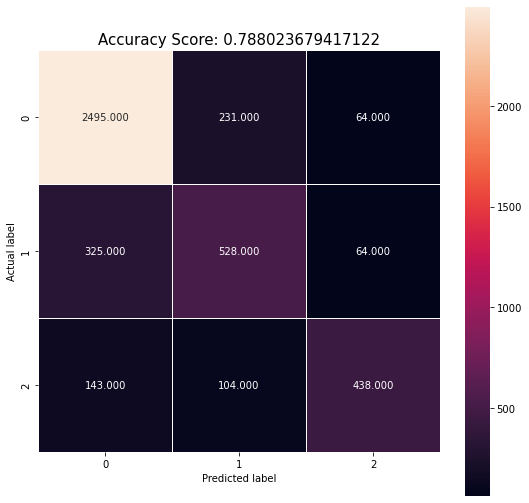

In [31]:
cm = metrics.confusion_matrix(y_test, y_pred)
score = logReg.score(X_test, y_test)

plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'rocket');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(score)
plt.title(all_sample_title, size = 15);

## Classification report

In [33]:
from sklearn.metrics import classification_report

In [ ]:
## ROC CURVE

## GridSearchCv for CountVect and Tf-idf

In [32]:
"""# Creating X, y Variables
X = cv.fit_transform(tweets['text'])
y = tweets['airline_sentiment']

# Setting up train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.30)

from sklearn.pipeline import Pipeline

# Pipeline & Gridsearch setup
# TFIDF pipeline setup

pipeline = Pipeline([
           ('vect', TfidfVectorizer()),
           ('clf', LogisticRegression()),
    
    'C' : [.01, .001, 1, 10, 100],#, 10, 100],
    'max_iter': [1000],
])
parameters = [{
    'vect__max_df': (0.5, 0.75, 1.0),
    'vect__max_features': (None, 5000, 10000, 50000),
    'vect__ngram_range': ((1, 1), (1, 2), (1,3)),  
    'tfidf__use_idf': (True, False),
    'tfidf__norm': ('l1', 'l2', None),
    'clf__max_iter': (100,1000),
    'clf__C': (0.00001, 0.000001, .01, .001, 1, 10, 100)
},{
    'vect': (CountVectorizer()),
    # count_vect_params...
    'clf__max_iter': (100,1000),
    'clf__C': (0.00001, 0.000001, .01, .001, 1, 10, 100)
}]

grid_search = GridSearchCV(pipeline, parameters)


######################################################

# Pipeline & Gridsearch setup
# TFIDF pipeline setup
tvc_pipe = Pipeline([
 (‘tvec’, TfidfVectorizer()),
 (‘mb’, MultinomialNB())
])
# Randomforest pipeline setup
rf_pipe = Pipeline([
 (‘tvec’, TfidfVectorizer()),
 (‘rf’, RandomForestClassifier())
])
# Fit
tvc_pipe.fit(X_train, y_train)
rf_pipe.fit(X_train, y_train)
# Setting params for TFIDF Vectorizer gridsearch
tf_params = {
 ‘tvec__max_features’:[100, 2000],
 ‘tvec__ngram_range’: [(1, 1), (1, 2), (2, 2)],
 ‘tvec__stop_words’: [None, ‘english’],
 
}
# Setting up randomforest params
rf_params = {
 ‘tvec__max_features’:[2000],
 ‘tvec__ngram_range’: [(1, 2)],
 ‘tvec__stop_words’: [‘english’],
 ‘rf__max_depth’: [1000],
 ‘rf__min_samples_split’: [100],
 ‘rf__max_leaf_nodes’: [None]
}"""

"# Creating X, y Variables\nX = cv.fit_transform(tweets['text'])\ny = tweets['airline_sentiment']\n\n# Setting up train test split\nX_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.30)\n\nfrom sklearn.pipeline import Pipeline\n\n# Pipeline & Gridsearch setup\n# TFIDF pipeline setup\n\npipeline = Pipeline([\n           ('vect', TfidfVectorizer()),\n           ('clf', LogisticRegression()),\n    \n    'C' : [.01, .001, 1, 10, 100],#, 10, 100],\n    'max_iter': [1000],\n])\nparameters = [{\n    'vect__max_df': (0.5, 0.75, 1.0),\n    'vect__max_features': (None, 5000, 10000, 50000),\n    'vect__ngram_range': ((1, 1), (1, 2), (1,3)),  \n    'tfidf__use_idf': (True, False),\n    'tfidf__norm': ('l1', 'l2', None),\n    'clf__max_iter': (100,1000),\n    'clf__C': (0.00001, 0.000001, .01, .001, 1, 10, 100)\n},{\n    'vect': (CountVectorizer()),\n    # count_vect_params...\n    'clf__max_iter': (100,1000),\n    'clf__C': (0.00001, 0.000001, .01, .001, 1, 10, 100)\n}]\n\ngrid_